# Recurrent Neural Networks

In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Then, we load the dataset:

In [3]:
sentiment_data = pd.read_csv('dataset.txt', sep='\t')
sentiment_data.columns =['Class', 'Data']
sentiment_data.describe()

,Class
count,6917.000000
mean,0.569900
std,0.495126
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Here, you can see some of the data:

In [4]:
sentiment_data.head()

,Class,Data
0,1,this was the first clive cussler i've ever rea...
1,1,i liked the Da Vinci Code a lot.
2,1,i liked the Da Vinci Code a lot.
3,1,I liked the Da Vinci Code but it ultimatly did...
4,1,that's not even an exaggeration ) and at midni...


# preview
we can see how many of sample are positive and how many of them are negative

In [5]:
sentiment_data.Class.value_counts()

1    3942
0    2975
Name: Class, dtype: int64

# clean up the text ( Data Preparation)
we clean up the text from punctuation (!@#$^& ...) then save the cleaned text in sentiment_data["Text_Clean"]

In [6]:
import re
import string
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords

def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct
sentiment_data['Text_Clean'] = sentiment_data['Data'].apply(lambda x: remove_punct(x))
#nltk.download('punkt')
tokens = [word_tokenize(sen) for sen in sentiment_data.Text_Clean]
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

After lower casing the data, stop words are removed from data using NLTK’s stopwords

In [7]:
#nltk.download('stopwords')
stoplist = stopwords.words('english')
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]
filtered_words = [removeStopWords(sen) for sen in lower_tokens]
sentiment_data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
sentiment_data['tokens'] = filtered_words

# create target 
in this section we create targets (pos =1 and neg=0)

In [8]:
pos = []
neg = []
for l in sentiment_data.Class:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
sentiment_data['Pos']= pos
sentiment_data['Neg']= neg
sentiment_data = sentiment_data[['Text_Final', 'tokens', 'Class', 'Pos', 'Neg']]
sentiment_data.head()


,Text_Final,tokens,Class,Pos,Neg
0,first clive cussler ive ever read even books l...,"[first, clive, cussler, ive, ever, read, even,...",1,1,0
1,liked da vinci code lot,"[liked, da, vinci, code, lot]",1,1,0
2,liked da vinci code lot,"[liked, da, vinci, code, lot]",1,1,0
3,liked da vinci code ultimatly didnt seem hold,"[liked, da, vinci, code, ultimatly, didnt, see...",1,1,0
4,thats even exaggeration midnight went walmart ...,"[thats, even, exaggeration, midnight, went, wa...",1,1,0


# randomiziation
with "train_test_split" function we commix the samples

In [9]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(sentiment_data, test_size=0.20, random_state=42)

# create training vocab

38155 words total, with a vocabulary size of 1842


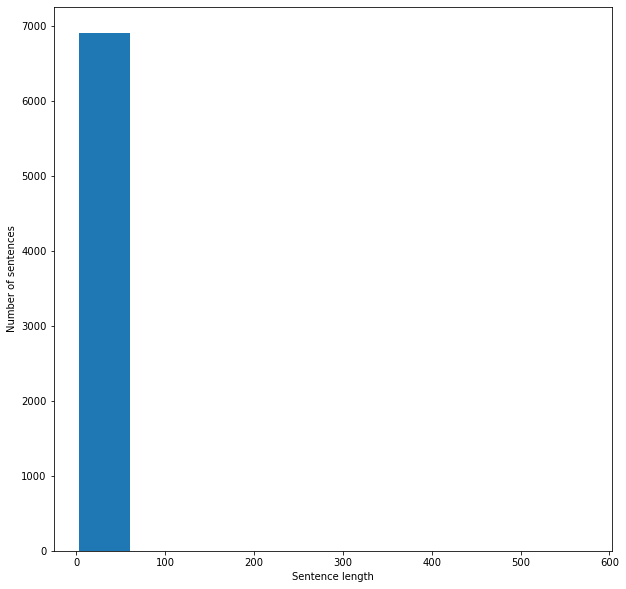

In [10]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in sentiment_data["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

9670 words total, with a vocabulary size of 823


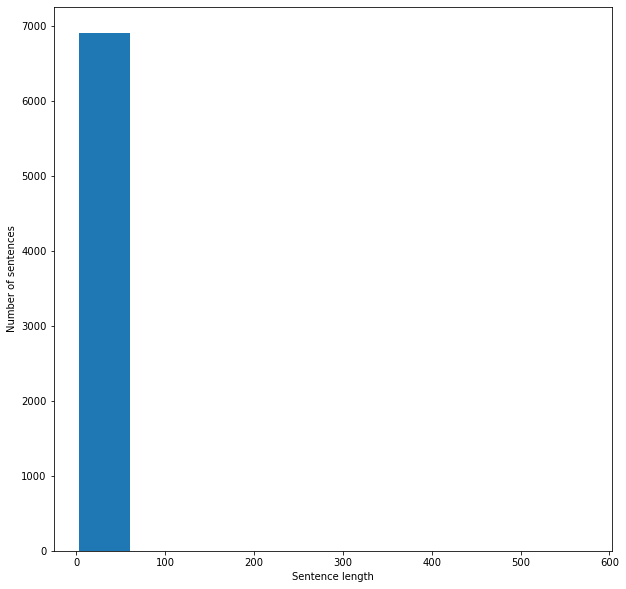

In [11]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in sentiment_data["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [12]:
import tensorflow as tf
config = tf.config.experimental
config.allow_growth = True #It prevents any new GPU process which consumes a GPU memory to be run on the same machine.
session = tf.compat.v1.Session()

in this section we use pre learned weights for work embedding 

In [13]:
import gensim
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [14]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [15]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

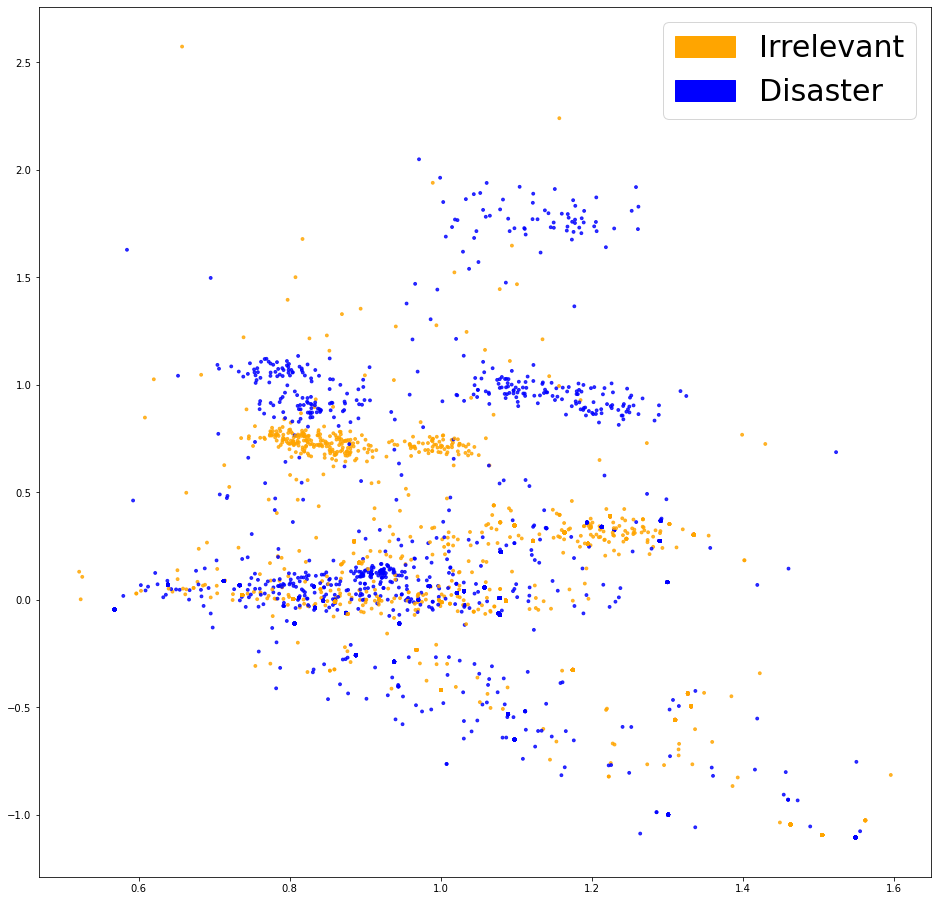

In [16]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)
len(training_embeddings)
fig1 = plt.figure(figsize=(16, 16))          
plot_LSA(training_embeddings, data_train.Class)
plt.show()

In [17]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 1841 unique tokens.


In [18]:

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(1842, 300)


In [19]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

in this section we create input trainning set and out put target

In [20]:
label_names = ['Pos', 'Neg']
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train

# create model
in this section we create model

In [21]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(tf.keras.layers.Embedding(len(train_word_index)+1,EMBEDDING_DIM,weights=[train_embedding_weights],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(tf.compat.v1.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(list(label_names)), activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           552600    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,156,122
Trainable params: 603,522
Non-trainable params: 552,600
_________________________________________________________________


In [22]:

num_epochs = 5
batch_size = 32
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 4979 samples, validate on 554 samples
Epoch 1/5
4979/4979 [==============================] - 136s 27ms/sample - loss: 0.1113 - acc: 0.9606 - val_loss: 0.0448 - val_acc: 0.9946

# test section 
in this section we test the model 


In [23]:
predictions = model.predict(test_cnn_data, batch_size=32, verbose=1)


1384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [25]:
labels = [1, 0]
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])
sum(data_test.Class==prediction_labels)/len(prediction_labels)

0.9877167630057804

In [27]:
from sklearn.metrics import classification_report
y_test = data_test['Class'].values
report = classification_report(y_test, prediction_labels, output_dict=True)
print(report)

{'0': {'precision': 0.9982363315696648, 'recall': 0.9725085910652921, 'f1-score': 0.9852045256744996, 'support': 582}, '1': {'precision': 0.9804161566707467, 'recall': 0.9987531172069826, 'f1-score': 0.9894996911673875, 'support': 802}, 'accuracy': 0.9877167630057804, 'macro avg': {'precision': 0.9893262441202058, 'recall': 0.9856308541361374, 'f1-score': 0.9873521084209436, 'support': 1384}, 'weighted avg': {'precision': 0.9879099007395115, 'recall': 0.9877167630057804, 'f1-score': 0.9876934871812164, 'support': 1384}}


In [ ]:

test_sequences = tokenizer.texts_to_sequences(["harry potter is very very very bad and suck movie"])
xx=tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict(xx, verbose=1)
print(predictions)
print("Pos labale: %.2f " % predictions[0][0])
print("Neg labale: %.2f " % predictions[0][1])